# Applying for the test

Consider a student who passed the SHSAT exam. First, he needed to pass through three steps:

- Applying for the test
- Taking the test
- Performing good at the test (better than the other students)

In this notebook, we will explore the first step. This is the step that PASSNYC seems to be most interested in. Also,
it is directly measurable (as in the District 5 dataset), but not its causes.

Question:

- What is needed for a student to apply for the test?

## Hypothesis

Let's consider that, for a student apply to a test, three elements must be present (all of them are necessary):

1. The student must know about the test
2. The student must determine the test is good for him
3. The student must have access to the way of applying to the test (the difficulty in this may interfere with element #2)

In [1]:
# first, we will see what can we get directly from the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
df = pd.read_csv('../data/raw/D5 SHSAT Registrations and Testers.csv')
df.head()

,DBN,School name,Year of SHST,Grade level,Enrollment on 10/31,Number of students who registered for the SHSAT,Number of students who took the SHSAT
0,05M046,P.S. 046 Arthur Tappan,2013,8,91,31,14
1,05M046,P.S. 046 Arthur Tappan,2014,8,95,26,7
2,05M046,P.S. 046 Arthur Tappan,2015,8,73,21,10
3,05M046,P.S. 046 Arthur Tappan,2016,8,56,20,8
4,05M123,P.S. 123 Mahalia Jackson,2013,8,62,31,14


In [18]:
df8 = df[df['Grade level'] == 8]
df9 = df[df['Grade level'] == 9]

## Enrollment vs. Students registered

In [35]:
def pct(f):
    return "{:.2f}".format(f) + "%"

enrolled = df8['Enrollment on 10/31'].sum()
registered = df8['Number of students who registered for the SHSAT'].sum()

print("8th grade\n")
print("students who registered:", registered)
print("students enrolled:", enrolled)
print("percentage:", pct(100 * registered / enrolled))

8th grade

students who registered: 2534
students enrolled: 6671
percentage: 37.99%


In [36]:
enrolled = df9['Enrollment on 10/31'].sum()
registered = df9['Number of students who registered for the SHSAT'].sum()

print("9th grade\n")
print("students who registered:", registered)
print("students enrolled:", enrolled)
print("percentage:", pct(100 * registered / enrolled))

9th grade

students who registered: 136
students enrolled: 6205
percentage: 2.19%


Nobody from the 9th grade registers for the test. We are gonna keep this as an observation and ignore this data from now on.

In [37]:
df = df8

### enrollment vs. student registered for each school (2016)

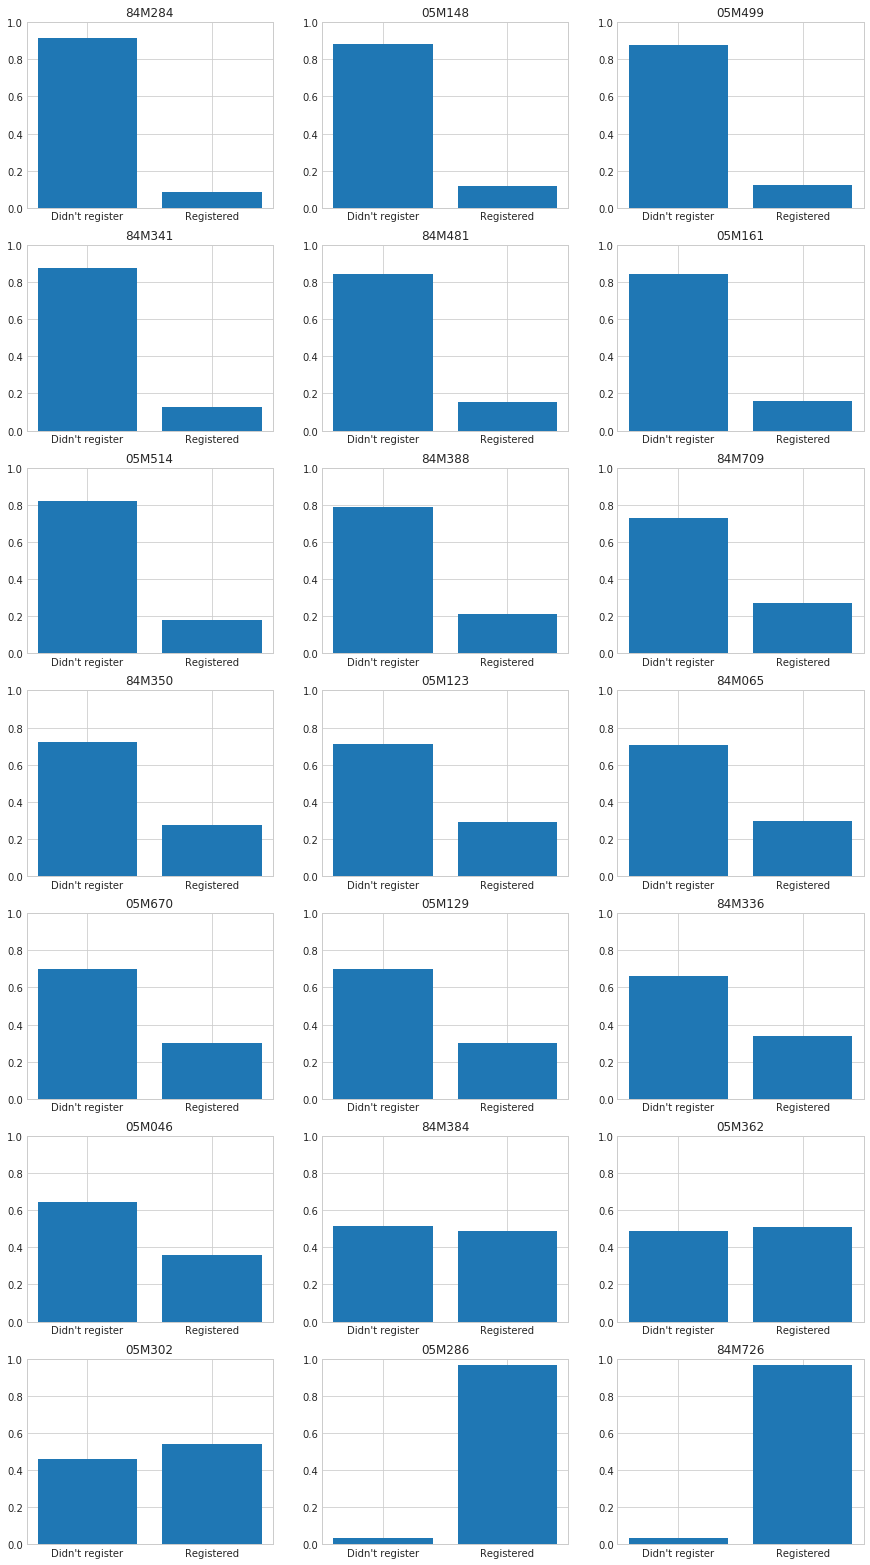

In [91]:
d = df[df['Year of SHST'] == 2016].copy()
d['register'] = d['Number of students who registered for the SHSAT'] / d['Enrollment on 10/31'] 
d['didnt_register'] = (d['Enrollment on 10/31'] - d['Number of students who registered for the SHSAT']) / d['Enrollment on 10/31'] 
d = d.sort_values('register')

fig, axes = plt.subplots(7, 3, figsize=(15, 28))

for i, (_, row) in enumerate(d.iterrows()):
    ax = axes[i // 3, i % 3]
    row = d.iloc[i]
    ax.set_title(row['DBN'])
    ax.bar([0,1], [row.didnt_register, row.register], tick_label=['Didn\'t register', 'Registered'])
    ax.set_ylim(bottom=0, top=1)

Most schools have few registers.

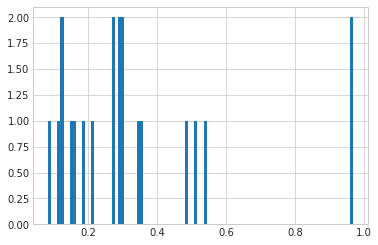

In [100]:
plt.hist(d['register'], bins=100);

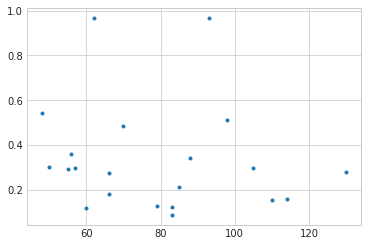

In [92]:
plt.plot(d['Enrollment on 10/31'], d['register'], '.')

The percentage doesn't seem related to the amount of students.

And it is fairly wide.

### enrollment vs. student registered for each school (time series)

In [115]:
d.DBN.unique().size

24

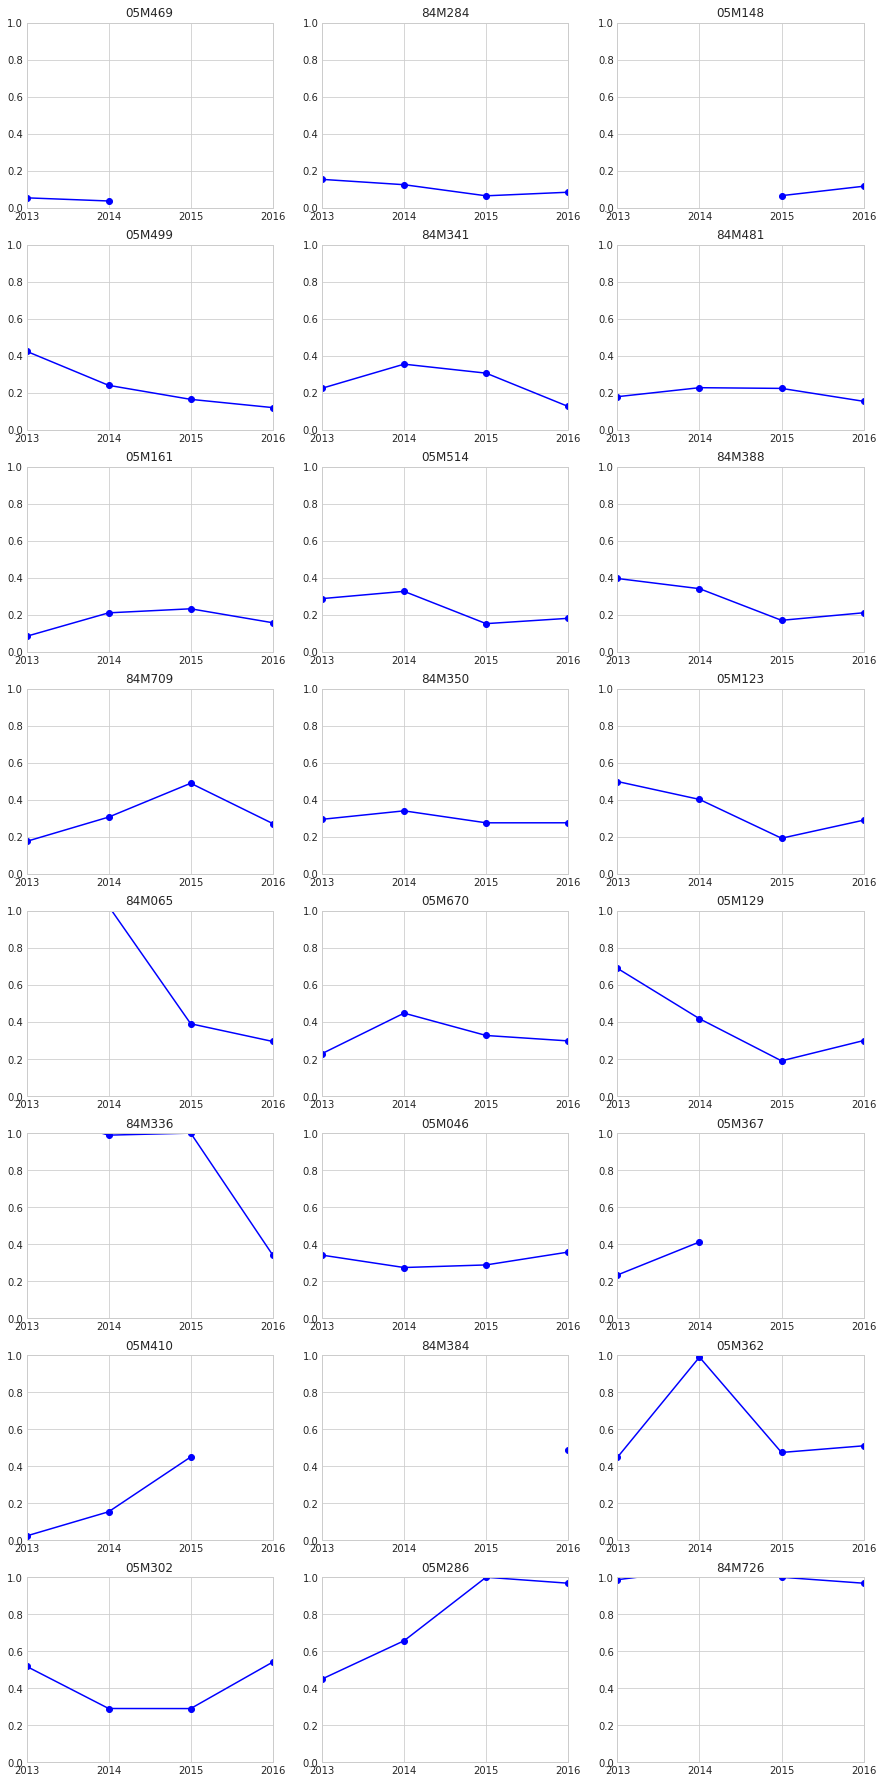

In [160]:
d = df.copy()
d['register'] = d['Number of students who registered for the SHSAT'] /  d['Enrollment on 10/31']
d['didnt_register'] = 1 - d['register']

last_register = d.groupby('DBN').apply(lambda df: df.sort_values('Year of SHST').iloc[-1].register).to_dict()                           
schools = sorted(d.groupby('DBN'), key=lambda x: last_register[x[0]])

fig, axes = plt.subplots(8, 3, figsize=(15,  32))

for i, (code, d) in enumerate(schools):
    ax = axes[i // 3, i % 3]
    ax.set_title(code)
    ax.plot(d['Year of SHST'], d['register'], 'bo-')
#     ax.plot(d['Year of SHST'], d['didnt_register'], 'ro-')
    ax.set_xlim(2013, 2016)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(2013, 2017))
    ax.set_yticks(np.arange(0, 1.1, 0.2))


# fig, axes = plt.subplots(8, 3, figsize=(15, 28))

# for i, (_, row) in enumerate(d.iterrows()):
#     ax = axes[i // 3, i % 3]
#     row = d.iloc[i]
#     ax.set_title(row['DBN'])
#     ax.bar([0,1], [row.didnt_register, row.register], tick_label=['Didn\'t register', 'Registered'])
#     ax.set_ylim(bottom=0, top=100)

Most schools seem fairly contant in the percentage of registrants. However, there are some with sudden jumps between the years. Why is it that some classes  (in the same school) have so much more applicants and some so fewer?

*Note*: The percentage of registered students may go above 100%, as the enrollment is calculated on a specific date, different then the date when the registration occur (when is it?).

In [162]:
df.loc[137].to_frame()  # example

,137
DBN,84M726
School name,KIPP STAR College Prep Charter School
Year of SHST,2014
Grade level,8
Enrollment on 10/31,71
Number of students who registered for the SHSAT,74
Number of students who took the SHSAT,19


---

In [11]:
schools = pd.read_csv('../data/raw/2016 School Explorer.csv')
df.DBN.isin(schools['Location Code']).sum()

113

In [15]:
# we lost 8 entries after performing the cleaning
# that is acceptable

schools = pd.read_pickle('../data/pre/schools2016.pkl')
df.DBN.isin(schools['Location Code']).sum()

105